In [1]:
### PREREQUISTIES
### (many used only in one notebook...)

import os
import pandas as pd
import numpy as np
import logging ### to monitor the code
from bs4 import BeautifulSoup
import pickle
import math
import random
import sys
import csv
import unicodedata
import requests
import re

import nltk
from nltk.collocations import *

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

import xml.etree.cElementTree as ET
from urllib.request import urlopen

import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe
#from google.colab import auth
#from oauth2client.client import GoogleCredentials
from google.oauth2 import service_account # based on google-auth library
import sddk

In [2]:
#!pip install anda
#from anda import gr ### the import takes substantial time, since it import a +600MB file containing ancient Greek dictionary

In [3]:
### not neccessary for reading the data, just for exporting them to sciencedata.dk
conf = sddk.configure()

sciencedata.dk username (format '123456@au.dk'): 648597@au.dk
sciencedata.dk password: ········
endpoint variable has been configured to: https://sciencedata.dk/files/


In [4]:
# to access gsheet, you need Google Service Account key json file
# I have mine located in my personal space on sciencedata.dk, so I read it from there:

# (1) read the file and parse its content
file_data = conf[0].get(conf[1] + "ServiceAccountsKey.json").json()
# (2) transform the content into crendentials object
credentials = service_account.Credentials.from_service_account_info(file_data)
# (3) specify your usage of the credentials
scoped_credentials = credentials.with_scopes(['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive'])
# (4) use the constrained credentials for authentication of gspread package
gc = gspread.Client(auth=scoped_credentials)
# (5) establish connection with spreadsheets specified by their url
PIA_data = gc.open_by_url("https://docs.google.com/spreadsheets/d/1KxOx7Be9fj3lDcEPgQhQ-Iqcn9p367-MMD6RMXe8rks/edit?usp=sharing")
PIA_overview = gc.open_by_url("https://docs.google.com/spreadsheets/d/1e94wyelg6dftQ4zxbq1xvwxWAI-BhcYXtclDW-YTnrw/edit?usp=sharing")

In [5]:
publicfolder = "31b393e2afe1ee96ce81869c7efe18cb"
c_hippocraticum = sddk.read_file("c_hippocraticum_enriched.json", "df", publicfolder)

reading file located in a public folder


In [67]:
c_hippocraticum["string"].apply(lambda x: x.count("ἢν")).sum()

2738

In [68]:
"ἤν"

'ἤν'

In [6]:
c_hippocraticum.columns

Index(['filename', 'author', 'title', 'string', 'wordcount', 'author_id',
       'doc_id', 'raw_date', 'date_avr', 'date_probs', 'date_manual',
       'provenience', 'sentences', 'lemmata', 'lemmata_wordcount',
       'lemmatized_sentences', 'n_sentences', 'lemmata_repl',
       'lemmatized_sentences_repl', 'λύπ*', 'ἄλγ*', 'ὀδύν*', 'πόνο*',
       'terms_sum', 'λύπ*_TF', 'ἄλγ*_TF', 'ὀδύν*_TF', 'πόνο*_TF', 'TF_sum',
       'work_cat_jouanna', 'work_cat_craik', 'work_cat_linka'],
      dtype='object')

In [8]:
c_hippocraticum["lemmata_repl"].apply(lambda x: x.count("ἔχις")).sum()

0

In [9]:
def term_in_sentences(sentences):
    flatlist = [word for sen in sentences for word in sen]
    return flatlist.count("ἔχις")
c_hippocraticum["lemmatized_sentences_repl"].apply(term_in_sentences).sum()

0

In [10]:
words = ['λύπ*', 'ἄλγ*', 'ὀδύν*', 'πόνο*']

In [11]:
def sentences_with_term(sentences, term, flatlist=False):
    sentences_with_term = [sen for sen in sentences if term in sen]
    if flatlist == True:
        flatlist = [word for sen in sentences_with_term for word in sen]
        return flatlist
    else: 
        return sentences_with_term

In [77]:
for word in words:
    c_hippocraticum[word + "_sents"] = c_hippocraticum["lemmatized_sentences_repl"].apply(lambda x: sentences_with_term(x, word, True))

In [107]:
for word in words:
    c_hippocraticum[word + "_sents"] = c_hippocraticum[word + "_sents"].apply(lambda sentences:  [word for word in sentences if word not in ["ἢν", "ὁκόταν"]])

In [108]:
wordlists = {}
for word in words:
    corpus_wordlist = []
    for wordlist in c_hippocraticum[word + "_sents"]:
        corpus_wordlist.extend(wordlist)
    wordlists[word] = corpus_wordlist

In [110]:
wordlists_freqs = {}
for word in words:
    word_counts = nltk.FreqDist(wordlists[word]).most_common(21)
    word_count = c_hippocraticum[word + "_sents"].apply(lambda x: len(x)).sum()
    word_freqs = [(tup[0], np.round(tup[1] / word_count, 5)) for tup in word_counts]
    wordlists_freqs[word + " word"] = [tup[0] for tup in word_counts]
wordlists_freqs_df = pd.DataFrame(wordlists_freqs)
wordlists_freqs_df

,λύπ* word,ἄλγ* word,ὀδύν* word,πόνο* word
0,λύπ*,ἄλγ*,ὀδύν*,πόνο*
1,γίγνομαι,πυρετός,ἔχω,γίγνομαι
2,ἄνθρωπος,κεφαλή,γίγνομαι,σῶμα
3,σῶμα,γίγνομαι,πυρετός,πολύς
4,πολύς,ἔχω,κεφαλή,ἔχω
5,κοιλία,ὀδύν*,γαστήρ,κοιλία
6,ἡμέρα,κοιλία,πολύς,μαλλός
7,εἶμι,γαστήρ,ἴσχω,πυρετός
8,ἔχω,ὀσφύς,κοιλία,πλείων
9,ὀλίγος,σῶμα,αἷμα,πᾶς


In [111]:
wordlists_freqs = {}
for word in words:
    word_freqs = nltk.FreqDist(wordlists[word]).most_common(21)
    wordlists_freqs[word + " (n={0})".format(word_freqs[0][1]) ] = word_freqs[1:]
wordlists_freqs_df = pd.DataFrame(wordlists_freqs)
wordlists_freqs_df

,λύπ* (n=58),ἄλγ* (n=315),ὀδύν* (n=642),πόνο* (n=651)
0,"(γίγνομαι, 14)","(πυρετός, 61)","(ἔχω, 168)","(γίγνομαι, 111)"
1,"(ἄνθρωπος, 12)","(κεφαλή, 61)","(γίγνομαι, 153)","(σῶμα, 102)"
2,"(σῶμα, 12)","(γίγνομαι, 51)","(πυρετός, 109)","(πολύς, 65)"
3,"(πολύς, 7)","(ἔχω, 47)","(κεφαλή, 89)","(ἔχω, 62)"
4,"(κοιλία, 7)","(ὀδύν*, 46)","(γαστήρ, 80)","(κοιλία, 59)"
5,"(ἡμέρα, 6)","(κοιλία, 42)","(πολύς, 66)","(μαλλός, 58)"
6,"(εἶμι, 6)","(γαστήρ, 35)","(ἴσχω, 62)","(πυρετός, 57)"
7,"(ἔχω, 6)","(ὀσφύς, 28)","(κοιλία, 50)","(πλείων, 56)"
8,"(ὀλίγος, 6)","(σῶμα, 26)","(αἷμα, 50)","(πᾶς, 55)"
9,"(χρόνος, 5)","(πᾶς, 23)","(ὀξύς, 44)","(χρόνος, 45)"


In [112]:
wordlists_freqs = {}
for word in words:
    word_counts = nltk.FreqDist(wordlists[word]).most_common(21)
    c_hippocraticum[word + "_sents"]
    word_count = c_hippocraticum[word + "_sents"].apply(lambda x: len(x)).sum()
    word_freqs = [(tup[0], np.round(tup[1] / word_count, 5)) for tup in word_counts]
    wordlists_freqs[word + " (n={0})".format(word_counts[0][1]) ] = word_freqs[1:]
wordlists_freqs_df = pd.DataFrame(wordlists_freqs)
wordlists_freqs_df

,λύπ* (n=58),ἄλγ* (n=315),ὀδύν* (n=642),πόνο* (n=651)
0,"(γίγνομαι, 0.01944)","(πυρετός, 0.01675)","(ἔχω, 0.02163)","(γίγνομαι, 0.01653)"
1,"(ἄνθρωπος, 0.01667)","(κεφαλή, 0.01675)","(γίγνομαι, 0.0197)","(σῶμα, 0.01519)"
2,"(σῶμα, 0.01667)","(γίγνομαι, 0.01401)","(πυρετός, 0.01404)","(πολύς, 0.00968)"
3,"(πολύς, 0.00972)","(ἔχω, 0.01291)","(κεφαλή, 0.01146)","(ἔχω, 0.00923)"
4,"(κοιλία, 0.00972)","(ὀδύν*, 0.01263)","(γαστήρ, 0.0103)","(κοιλία, 0.00879)"
5,"(ἡμέρα, 0.00833)","(κοιλία, 0.01154)","(πολύς, 0.0085)","(μαλλός, 0.00864)"
6,"(εἶμι, 0.00833)","(γαστήρ, 0.00961)","(ἴσχω, 0.00798)","(πυρετός, 0.00849)"
7,"(ἔχω, 0.00833)","(ὀσφύς, 0.00769)","(κοιλία, 0.00644)","(πλείων, 0.00834)"
8,"(ὀλίγος, 0.00833)","(σῶμα, 0.00714)","(αἷμα, 0.00644)","(πᾶς, 0.00819)"
9,"(χρόνος, 0.00694)","(πᾶς, 0.00632)","(ὀξύς, 0.00567)","(χρόνος, 0.0067)"


In [21]:
set_with_dataframe(PIA_overview.add_worksheet("tfs-in-sentences", 1, 1), wordlists_freqs_df)

In [113]:
wordlists_freqs = {}
for word in words:
    word_counts = nltk.FreqDist(wordlists[word]).most_common(21)
    c_hippocraticum[word + "_sents"]
    word_count = c_hippocraticum[word + "_sents"].apply(lambda x: len(x)).sum()
    tfs = [np.round(tup[1] / word_count, 5) for tup in word_counts]
    tf_words = [tup[0] for tup in word_counts]
    wordlists_freqs[word + " words"] = tf_words[1:]
    wordlists_freqs[word + " TFs"] = tfs[1:]
wordlists_freqs_df = pd.DataFrame(wordlists_freqs)
wordlists_freqs_df

,λύπ* words,λύπ* TFs,ἄλγ* words,ἄλγ* TFs,ὀδύν* words,ὀδύν* TFs,πόνο* words,πόνο* TFs
0,γίγνομαι,0.01944,πυρετός,0.01675,ἔχω,0.02163,γίγνομαι,0.01653
1,ἄνθρωπος,0.01667,κεφαλή,0.01675,γίγνομαι,0.01970,σῶμα,0.01519
2,σῶμα,0.01667,γίγνομαι,0.01401,πυρετός,0.01404,πολύς,0.00968
3,πολύς,0.00972,ἔχω,0.01291,κεφαλή,0.01146,ἔχω,0.00923
4,κοιλία,0.00972,ὀδύν*,0.01263,γαστήρ,0.01030,κοιλία,0.00879
5,ἡμέρα,0.00833,κοιλία,0.01154,πολύς,0.00850,μαλλός,0.00864
6,εἶμι,0.00833,γαστήρ,0.00961,ἴσχω,0.00798,πυρετός,0.00849
7,ἔχω,0.00833,ὀσφύς,0.00769,κοιλία,0.00644,πλείων,0.00834
8,ὀλίγος,0.00833,σῶμα,0.00714,αἷμα,0.00644,πᾶς,0.00819
9,χρόνος,0.00694,πᾶς,0.00632,ὀξύς,0.00567,χρόνος,0.00670


In [114]:
cats = c_hippocraticum["work_cat_linka"].unique().tolist()
cats

['Theoretical', 'Other', 'Practical']

In [115]:
most_common = []
for word in words:
    wordlist = wordlists_freqs_df[word + " words"].tolist()
    most_common.extend(wordlist)
most_common_unique = list(set(most_common))
most_common_unique_df = pd.DataFrame(most_common_unique)

In [161]:
terms_by_cat_df = get_as_dataframe(PIA_overview.worksheet("terms_by_cat"))
terms_by_cat_dict = dict(zip(terms_by_cat_df["term"], terms_by_cat_df["term_category"]))
terms_by_cat_dict

{'πρότερος': 'temporal quality',
 'ψυχρός': 'quality',
 'λαμβάνω': 'verb',
 'κεφαλή': 'bodily parts and constituents',
 'ἰσχυρός': 'quality',
 'ἄνθρωπος': 'bodily parts and constituents',
 'χολή': 'bodily parts and constituents',
 'ὁπόσος': 'quality',
 'ἄλγ*': 'pain-word',
 'τρίτος': 'quality',
 'πᾶς': 'quality',
 'πλείων': 'quality',
 'σάρξ': 'bodily parts and constituents',
 'συμβαίνω': 'verb',
 'θερμός': 'quality',
 'μαλλός': 'quality',
 'ἡμέρα': 'temporal quality',
 'πόνο*': 'pain-word',
 'ὀδύν*': 'pain-word',
 'κοιλία': 'bodily parts and constituents',
 'εἶμι': 'verb',
 'ποιέω': 'verb',
 'γίγνομαι': 'verb',
 'ἔχω': 'verb',
 'καθίημι': 'verb',
 'δοκέω': 'verb',
 'δίδωμι': 'verb',
 'ὀξύς': 'quality',
 'πολύς': 'quality',
 'μήτρα': 'bodily parts and constituents',
 'ἰξύς': 'bodily parts and constituents',
 'κενεών': 'bodily parts and constituents',
 'χρόνος': 'temporal quality',
 'σιτίον': 'pathological state',
 'ἴσχω': 'verb',
 'ἐσθίω': 'verb',
 'νόσος': 'pathological state',
 'σῶμα

In [162]:
# https://matplotlib.org/3.1.0/gallery/color/named_colors.html
import matplotlib.colors as mcolors
colors_list = list(mcolors.TABLEAU_COLORS.keys()) + list(mcolors.BASE_COLORS.keys())
print(colors_list)

['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']


In [163]:
# remove white
colors_list = [col for col in colors_list if col not in ["b", "w"]] 

In [164]:
term_cats = list(set(terms_by_cat_dict.values()))
print(term_cats)

['bodily parts and constituents', 'temporal quality', 'verb', 'pain-word', 'quality', 'pathological state']


In [208]:
colors = ["purple", "blue", "green", "black", "red", "yellow"]
cat_colors_dict = dict(zip(term_cats, colors))
cat_colors_dict

{'bodily parts and constituents': 'purple',
 'temporal quality': 'blue',
 'verb': 'green',
 'pain-word': 'black',
 'quality': 'red',
 'pathological state': 'yellow'}

In [166]:
cat_colors_dict["bodily parts and constituents"] #terms_by_col_dict[key]]

'purple'

In [167]:
cat_colors_dict[terms_by_cat_dict["γίγνομαι"]]

'green'

In [168]:
terms_by_col_dict = {}
for key in terms_by_cat_dict.keys():
    #print(key)
    terms_by_col_dict[key] = cat_colors_dict[terms_by_cat_dict[key]]

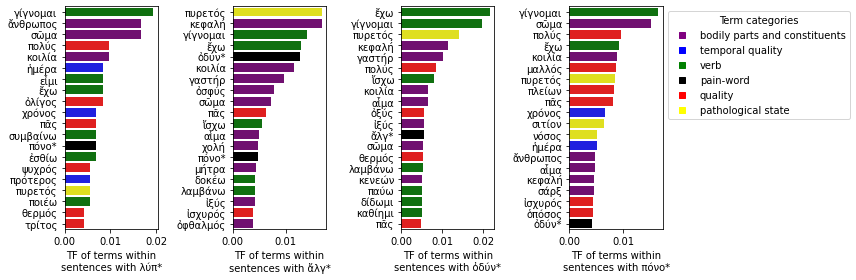

In [209]:
#plt.rcParams['figure.figsize'] = [12, 4]
fig, axs = plt.subplots(1, 4, figsize=[12,4], tight_layout=True)

for word, ax in zip(words, axs):
    xcol = wordlists_freqs_df[word + " TFs"]
    ycol = wordlists_freqs_df[word + " words"]
    actual_colors = [terms_by_col_dict[word] for word in ycol]
    sns.barplot(x=xcol, y=ycol, palette=actual_colors, ax=ax)
    ax.set(ylabel="", xlabel="TF of terms within\nsentences with " + word)

plt.subplots_adjust(hspace=0.08) # top=1, bottom=0, left=0, right=1, hspace=0.08, wspace=1.2)

#plt.title("Most frequent terms in sentences containing pain-words                       ", loc="right")

markers = [plt.Line2D([0,0],[0,0],color=color, marker="s", linestyle="") for color in colors]
plt.legend(markers, term_cats, numpoints=1,  title="Term categories", bbox_to_anchor=(1, 1), loc='upper left')

In [210]:
sddk.write_file("public_data/PIA/terms_in_sentences.png", fig, conf)

A file with the same name ("terms_in_sentences.png") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/public_data/PIA/terms_in_sentences.png"


https://sciencedata.dk/public/31b393e2afe1ee96ce81869c7efe18cb/terms_in_sentences.png